

---


# Class incremental learning on the GTSRB dataset



---
In this project, we explore the problem of catastrophic forgetting in incremental learning of traffic signs. When new classes are gradually added to the model, it tends to forget previous knowledge if it is not trained with appropriate mechanisms.  

To guide our implementation, we primarily relied on the provided documentation, as well as several scientific articles and technical resources on incremental learning and knowledge consolidation methods in deep learning. These references helped us better understand the challenges of catastrophic forgetting and explore effective solutions to improve the model's performance.  

Our experiments aim to compare different methods and evaluate their effectiveness in an incremental learning scenario.

Groupe 13:
- Gabriel Baptista Trellesse
- Rodrigo Botelho Zuiani
- Maria Fernanda Pereira Betim Paes Leme



In [ ]:
####################################
### Useful imports
############################

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid
from torchvision import transforms, datasets
import torchvision.models as models
from torchvision.transforms import v2
import copy

import numpy as np
import random
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Useful if you want to store intermediate results on your drive
from google.colab import drive

#drive.mount('/content/gdrive/')
#DATA_DIR =  '/content/gdrive/MyDrive/teaching/ENSTA/2024'


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
  !nvidia-smi

## Data loaders

In [ ]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    #transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
])

transform_train = v2.Compose([
    #v2.Grayscale(),
    #v2.RandomResizedCrop(32),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669)) # GTSRB stats
])

# Define dataset and dataloader
def get_dataset(root_dir, transform, train=True):
    dataset = datasets.GTSRB(root=root_dir, split='train' if train else 'test', download=True, transform=transform)
    target = [data[1] for data in dataset]
    return dataset, target

def create_dataloader(dataset, targets, current_classes, batch_size, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [ ]:
# Loads datasets (on your local computer)
#root_dir = '/home/rodri/OneDrive/Documentos/ENSTA/2A/ML/Incremental-Learning/'

# Loads datasets (on Colab local computer)
root_dir = './data'

train_dataset = datasets.GTSRB(root=root_dir, split='train', download=True, transform=transform_train)
test_dataset = datasets.GTSRB(root=root_dir, split='test', download=True, transform=transform_test)

print(f"Train dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")

# Loads target id lists (not in torchvision dataset)rm *.
import csv
! wget https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/test_target.csv -O data/gtsrb/test_target.csv
test_target=[]
with open('data/gtsrb/test_target.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        test_target += [int(el) for el in row]

! wget https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/train_target.csv -O data/gtsrb/train_target.csv
train_target=[]
with open('data/gtsrb/train_target.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        train_target += [int(el) for el in row]

# Loads class names (not in torchvision dataset)
! wget https://raw.githubusercontent.com/stepherbin/teaching/refs/heads/master/ENSTA/MI201/signnames.csv -O data/gtsrb/signnames.csv
classes = pd.read_csv('data/gtsrb/signnames.csv')
class_names = []
for i, row in classes.iterrows():
    class_names.append(row[1])

In [ ]:
nclasses = len(np.unique(train_target))
all_classes = list(range(nclasses))
#random.shuffle(all_classes)
classes_per_task = 8
current_classes = []

task = 0
task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
current_classes.extend(task_classes)
batch_size = 64

# Create data for first task
train_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)
test_loader = create_dataloader(train_dataset, train_target, current_classes, batch_size, shuffle = True)

# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(train_loader))
show(make_grid(sample))
plt.show()

print(sample.shape)     ## 64 is the batch
                        ## 1 for grey values --  3 for RGB
                        ## 32x32 for mage size (small here)


## Display of images

In [ ]:
test_loader = create_dataloader(train_dataset, train_target, all_classes, batch_size, shuffle = True)

# Get the data from the test set and computes statistics
# gtsrbtest_gt = []
# for _, targets in test_loader:
#   gtsrbtest_gt += targets.numpy().tolist()
# print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(test_target).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

## Simple networks

In [ ]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc = nn.Linear(4096, n_out)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.fc(x) ## on finit exactement de la même façon

        return x

# Another simple model (compare them using torchinfo below)
class SimpleCNN2(nn.Module):
    def __init__(self, n_out=10, n_in=1):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc = nn.Linear(128, n_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc(x)
        return x

In [ ]:
!pip install torchinfo
from torchinfo import summary

model = SimpleCNN2(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

model = SimpleCNN(n_out=10, n_in=3)
model.to(device)
print(summary(model, input_size=(batch_size, 3, 32, 32)))

#print(model)

## Baseline for incremental learning

In [ ]:
from torch.optim import lr_scheduler
import torch.nn.init as init

# Evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, ncols=80):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Simple Training loop
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()

    for images, labels in tqdm(train_loader, ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def initialize_weights(module):
    """Initializes the weights of a PyTorch module using Xavier/Glorot initialization."""
    if isinstance(module, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):  # Check for relevant layers
        init.xavier_uniform_(module.weight) #Xavier uniform initialization
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize bias to zero
    elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)): #Initialize normalization layers
        if module.weight is not None:
            init.ones_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)


# Main training loop for incremental learning
def incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    for task in range(num_tasks):
        task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
        current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs as needed
            train(model, train_loader, optimizer, criterion, device, epoch)
            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")
        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

    return accuracies



## Weight & Biases

You can use this environement to log your learning.

The code below provides a version of the class incremental function that stores learning curves and the seauence of accuracies for each increment of classes.

Tu use it, create an account at: https://wandb.ai/

In [ ]:
###################################
##### For using Weight & Biases
###############

!pip install wandb -qU

import wandb

wandb.login()


In [ ]:
import math
# Simple Training loop
def train_wandb(model, train_loader, optimizer, criterion, device, epoch):

    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1


# Main training loop for incremental learning
def incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            #train(model, train_loader, optimizer, criterion, device, epoch)

            # If logging training (but not incremental)
            train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}
            #wandb.log({**val_metrics})

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Log train and validation metrics to wandb

    return accuracies



## Pre-Training

In [ ]:
# Hyperparameters
root_dir = './data'  # Path to GTSRB dataset
num_tasks = 5
numclasses = len(np.unique(train_target))
classes_per_task = numclasses // num_tasks #43/2 ~ 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

buffer_size = 200 # Adjust rehearsal set size
alignment_strength = 0.1 # Adjust alignment strength
num_epochs = 4

#model = SimpleCNN(n_out = 1, n_in = 3).to(device)
#model.apply(initialize_weights)

# The name of the network (choose the on you want)
tag = "simpleCNN_GTSRB_pretrained"
netname = os.path.join(root_dir, 'network_{:s}.pth'.format(tag))

#################################################
## Pre-training
####

# Read the last learned network (if stored)
if (os.path.exists(netname)):
    print('Load pre-trained network')
    model = SimpleCNN(n_in = 3, n_out=classes_per_task)
    model.load_state_dict(torch.load(netname,weights_only=True))

    #model = torch.load(netname, weights_only=True)
    model = model.to(device)
else:
    print('Pretrain')
    model = SimpleCNN(n_in = 3, n_out=1)
    model.apply(initialize_weights)
    model.to(device)

    accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                        1, classes_per_task, batch_size, num_epochs, lr, device)

    print(f"!!!!! Pre-training on first task  = {accu[0]:.2f}%")

    # Save last learned model
    #torch.save(model, netname)
    torch.save(model.state_dict(), netname)

## Copy model to have the same initialization
copy_model = copy.deepcopy(model) # Copy model to start from the same initialization

#### Learn with a single epoch in incremental (faster but less accurate)
num_epochs = 1


## Fine tuning

In [ ]:
#############################################
## Fine tuning
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Fine tuning",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Simple Incremental Fine Tuning
model = copy.deepcopy(copy_model)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


## Upper bound

In [ ]:
#################################################
## Global upper bound (all data, all classes)
####

# One task + all classes computed using 5 epochs
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound 1 task",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })
model = copy.deepcopy(copy_model)
accu = incremental_learning(model, train_dataset, train_target, test_dataset, test_target,
                      1, (numclasses // num_tasks) * num_tasks, batch_size, 5, lr, device)

print(f"!!!!! Upper bound of accuracy = {accu[0]:.2f}%")
wandb.finish()


In [ ]:
########################################
## Upper bound for each task (takes some time)
####
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Upper bound",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Non incremental data (learn all classes from all data for each task)
model = SimpleCNN(n_in = 3, n_out=1)
model.apply(initialize_weights)
model.to(device)
incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = True)

wandb.finish()

## Avoiding Forgetting

To counter this phenomenon, we tested two main approaches:  

- **Rehearsal**: Storing a subset of past data to retrain the model on previously learned classes using a memory buffer.  
- **Rehearsal + Knowledge Distillation (KD)**: Combining memory replay with knowledge distillation to align the current model’s predictions with those of a teacher model.

### Rehearsal + KD

One of the major challenges when applying Knowledge Distillation (KD) in incremental learning is that the last layer of the student model differs from that of the teacher model. With each new task, the student model is updated to recognize additional classes, increasing the size of the output (fully connected) layer. This creates an incompatibility between the predictions of the student and teacher models, making it difficult to align output distributions through knowledge distillation.  

To address this issue, we implemented a **"weight matching"** strategy:  

1. **Copying the weights of previous classes**: When a new task is added, we copy the weights from the old fully connected (FC) layer into the expanded FC layer, ensuring that previous class representations are retained.  
2. **Selective update of the last layer**: We transfer only the weights corresponding to past classes while allowing new classes to be learned normally.  
3. **Freezing the teacher model’s weights**: To prevent the teacher model from changing over iterations, we keep it in evaluation mode and block any updates to its weights.

In [1]:
import collections

# Rehearsal memory buffer
class MemoryBuffer:
    def __init__(self, size):
        self.size = size
        self.memory = collections.defaultdict(list)  # Store samples per class
         # Copy model to start from the same initialization

    def add_samples(self, images, labels):
        for img, lbl in zip(images, labels):
            # Keep buffer balanced by limiting samples per class
            if len(self.memory[lbl]) > self.size // len(self.memory):
                self.memory[lbl].pop(random.randint(0, len(self.memory[lbl]) - 1))  # Random removal

            self.memory[lbl].append(img)

    def get_samples(self, num_samples):
        samples = []
        classes = list(self.memory.keys())
        if len(self.memory) < num_samples:
            num_samples = len(self.memory)

        while len(samples) < num_samples:
            cls = random.choice(classes)
            if self.memory[cls]:  # Ensure class has data
                samples.append((self.memory[cls].pop(0), cls))  # Pop oldest sample

        return samples

def create_dataloader_rehearsal(dataset, targets, current_classes, batch_size, mem_labels, shuffle):
    indices = [i for i, label in enumerate(targets) if label in current_classes or label in mem_labels]
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def get_indices_rehearsal(dataset, targets, current_classes):
    indices = [i for i, label in enumerate(targets) if label in current_classes]
    return indices

def get_labels_rehearsal(dataset, targets, current_classes, indices):
    labels = [label for i, label in enumerate(targets) if label in current_classes and i in indices]
    return labels

In [ ]:
def distillation_loss(student_outputs, teacher_outputs, temperature=2.0):
    # Ensure student logits only consider old class outputs
    student_outputs = student_outputs[:, :teacher_outputs.shape[1]]

    soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
    soft_preds = nn.functional.log_softmax(student_outputs / temperature, dim=1)
  #Compares the soft loss of both teacher and student
    return nn.functional.kl_div(soft_preds, soft_targets, reduction='batchmean')

First try with a factor of distillation_loss = 0.1

In [ ]:
# Modified Training loop
def rehearsal_kd_train_wandb(model, train_loader, optimizer, criterion, device, epoch, teacher_model = None):
    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)#hard loss

        # Knowledge Distillation Loss
        if teacher_model:
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss += 0.1 * distillation_loss(outputs[:, :teacher_outputs.shape[1]], teacher_outputs, temperature=2.0)

        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1

# Training loop for modified incremental learning
def rehearsal_kd_incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []
    memory_buffer = MemoryBuffer(size=200)
    teacher_model = copy.deepcopy(model)
    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        if task == 0:
            train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        else:
            # Rehearsal
            mem_samples = memory_buffer.get_samples(train_loader.batch_size * 2)
            mem_images, mem_labels = zip(*mem_samples)
            mem_labels = torch.tensor(mem_labels).to(device)
            train_loader = create_dataloader_rehearsal(train_dataset, train_target, task_classes, batch_size, mem_labels, shuffle = True)


        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            # If logging training (but not incremental)
            rehearsal_kd_train_wandb(model, train_loader, optimizer, criterion, device, epoch, teacher_model)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Rehearsal
        indices = get_indices_rehearsal(train_dataset, train_target, task_classes)
        sampled_indices = random.sample(indices, min(200, len(indices)))
        mem_images = []
        mem_labels = get_labels_rehearsal(train_dataset, train_target, task_classes, sampled_indices)
        for i in sampled_indices:
            mem_images.append(train_dataset[i][0])
        memory_buffer.add_samples(mem_images, mem_labels)

        # Update teacher model and memory buffer
        if task == 0:  # For the first task, initialize the teacher model
          teacher_model = copy.deepcopy(model)
        else:
            # Ensure teacher model output layer matches the student model's new architecture
            #teacher_model.fc = nn.Linear(model.fc.in_features, model.fc.out_features).to(device)
             #1. Create a new teacher model with the updated output size
            new_teacher_model = copy.deepcopy(model)  # Start with a copy of the current model

            # 2. Copy the weights of the common layers (everything except the last FC layer)
            for name, param in model.named_parameters():
                if "fc" not in name:  # Copy everything but the final fc layer
                    try:
                        new_teacher_model.state_dict()[name].copy_(param.data)
                    except RuntimeError as e:
                        print(f"Warning: Layer {name} not found in teacher model. Skipping. Error: {e}")


            # 3. For the FC layer, copy the weights corresponding to the *old* classes.
            old_teacher_fc_weight = teacher_model.fc.weight.data  # The previous FC weights
            new_teacher_fc_weight = new_teacher_model.fc.weight.data  # The new FC weights

            common_classes = min(old_teacher_fc_weight.shape[0], new_teacher_fc_weight.shape[0]) #Number of overlapping classes
            new_teacher_fc_weight[:common_classes] = old_teacher_fc_weight[:common_classes] # Copy the weights for the common classes


            new_teacher_model.fc.weight.data = new_teacher_fc_weight
            new_teacher_model.fc.bias.data[:common_classes] = teacher_model.fc.bias.data[:common_classes]

            teacher_model = new_teacher_model # Update the teacher model.
            del new_teacher_model #Delete the temporary teacher model.


            # Copy the entire model's state dictionary with mismatches ignored
            #teacher_model.load_state_dict(model.state_dict(), strict=False)
            #teacher_model.load_state_dict(model.state_dict())
            # Set to evaluation mode and freeze parameters
        teacher_model.eval()
        for param in teacher_model.parameters():
            param.requires_grad = False  # Ensures it remains frozen

    return accuracies


In [4]:
#############################################
## Rehearsal with KD
#############################################
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Rehearsal + KD (0.1)",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Incremental with Reheasal
model = copy.deepcopy(copy_model)
rehearsal_kd_incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


NameError: name 'wandb' is not defined

Second try with a factor of distillation_loss = 0.5

In [ ]:
# Modified Training loop
def rehearsal_kd_train_wandb2(model, train_loader, optimizer, criterion, device, epoch, teacher_model = None):
    step_ct = 0
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / train_loader.batch_size)

    model.train()

    for step, (images, labels) in tqdm(enumerate(train_loader), ncols=80,  desc="Epoch {}".format(epoch)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)#hard loss

        # Knowledge Distillation Loss
        if teacher_model:
            with torch.no_grad():
                teacher_outputs = teacher_model(images)
            loss += 0.5 * distillation_loss(outputs[:, :teacher_outputs.shape[1]], teacher_outputs, temperature=2.0)

        loss.backward()
        optimizer.step()

        metrics = {"train/train_loss": loss}
        # metrics = {"train/train_loss": loss,
        #             "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch}

        if step + 1 < n_steps_per_epoch:
          # Log train metrics to wandb
          wandb.log(metrics)
        step_ct += 1

# Training loop for modified incremental learning
def rehearsal_kd_incremental_learning_wandb2(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []
    memory_buffer = MemoryBuffer(size=200)
    teacher_model = copy.deepcopy(model)
    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        if task == 0:
            train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        else:
            # Rehearsal
            mem_samples = memory_buffer.get_samples(train_loader.batch_size * 2)
            mem_images, mem_labels = zip(*mem_samples)
            mem_labels = torch.tensor(mem_labels).to(device)
            train_loader = create_dataloader_rehearsal(train_dataset, train_target, task_classes, batch_size, mem_labels, shuffle = True)


        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            # If logging training (but not incremental)
            rehearsal_kd_train_wandb2(model, train_loader, optimizer, criterion, device, epoch, teacher_model)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Rehearsal
        indices = get_indices_rehearsal(train_dataset, train_target, task_classes)
        sampled_indices = random.sample(indices, min(200, len(indices)))
        mem_images = []
        mem_labels = get_labels_rehearsal(train_dataset, train_target, task_classes, sampled_indices)
        for i in sampled_indices:
            mem_images.append(train_dataset[i][0])
        memory_buffer.add_samples(mem_images, mem_labels)

        # Update teacher model and memory buffer
        if task == 0:  # For the first task, initialize the teacher model
          teacher_model = copy.deepcopy(model)
        else:
            # Ensure teacher model output layer matches the student model's new architecture
            #teacher_model.fc = nn.Linear(model.fc.in_features, model.fc.out_features).to(device)
             #1. Create a new teacher model with the updated output size
            new_teacher_model = copy.deepcopy(model)  # Start with a copy of the current model

            # 2. Copy the weights of the common layers (everything except the last FC layer)
            for name, param in model.named_parameters():
                if "fc" not in name:  # Copy everything but the final fc layer
                    try:
                        new_teacher_model.state_dict()[name].copy_(param.data)
                    except RuntimeError as e:
                        print(f"Warning: Layer {name} not found in teacher model. Skipping. Error: {e}")


            # 3. For the FC layer, copy the weights corresponding to the *old* classes.
            old_teacher_fc_weight = teacher_model.fc.weight.data  # The previous FC weights
            new_teacher_fc_weight = new_teacher_model.fc.weight.data  # The new FC weights

            common_classes = min(old_teacher_fc_weight.shape[0], new_teacher_fc_weight.shape[0]) #Number of overlapping classes
            new_teacher_fc_weight[:common_classes] = old_teacher_fc_weight[:common_classes] # Copy the weights for the common classes


            new_teacher_model.fc.weight.data = new_teacher_fc_weight
            new_teacher_model.fc.bias.data[:common_classes] = teacher_model.fc.bias.data[:common_classes]

            teacher_model = new_teacher_model # Update the teacher model.
            del new_teacher_model #Delete the temporary teacher model.


            # Copy the entire model's state dictionary with mismatches ignored
            #teacher_model.load_state_dict(model.state_dict(), strict=False)
            #teacher_model.load_state_dict(model.state_dict())
            # Set to evaluation mode and freeze parameters
        teacher_model.eval()
        for param in teacher_model.parameters():
            param.requires_grad = False  # Ensures it remains frozen

    return accuracies


In [ ]:
#############################################
## Rehearsal with KD
########
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Rehearsal + KD (0.5)",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Incremental with Reheasal
model = copy.deepcopy(copy_model)
rehearsal_kd_incremental_learning_wandb2(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


Starting Task 1 - Training on classes: [0, 1, 2, 3, 4, 5, 6, 7]


Epoch 0: 125it [00:31,  3.99it/s]
100%|█████████████████████████████████████████| 125/125 [00:12<00:00, 10.34it/s]


Task 1, Epoch 1: Accuracy Train = 96.29%


100%|███████████████████████████████████████████| 61/61 [00:05<00:00, 11.53it/s]


Task 1: Accuracy Test = 88.22%
Starting Task 2 - Training on classes: [8, 9, 10, 11, 12, 13, 14, 15]


Epoch 0: 203it [00:53,  3.82it/s]
100%|█████████████████████████████████████████| 203/203 [00:20<00:00,  9.71it/s]


Task 2, Epoch 1: Accuracy Train = 97.00%


100%|█████████████████████████████████████████| 122/122 [00:11<00:00, 10.63it/s]


Task 2: Accuracy Test = 85.95%
Starting Task 3 - Training on classes: [16, 17, 18, 19, 20, 21, 22, 23]


Epoch 0: 223it [01:00,  3.68it/s]
100%|█████████████████████████████████████████| 223/223 [00:21<00:00, 10.34it/s]


Task 3, Epoch 1: Accuracy Train = 99.61%


100%|█████████████████████████████████████████| 144/144 [00:14<00:00, 10.07it/s]


Task 3: Accuracy Test = 86.13%
Starting Task 4 - Training on classes: [24, 25, 26, 27, 28, 29, 30, 31]


Epoch 0: 248it [01:07,  3.69it/s]
100%|█████████████████████████████████████████| 248/248 [00:24<00:00,  9.92it/s]


Task 4, Epoch 1: Accuracy Train = 99.28%


100%|█████████████████████████████████████████| 167/167 [00:16<00:00, 10.12it/s]


Task 4: Accuracy Test = 79.28%
Starting Task 5 - Training on classes: [32, 33, 34, 35, 36, 37, 38, 39]


Epoch 0: 254it [01:07,  3.75it/s]
100%|█████████████████████████████████████████| 254/254 [00:25<00:00,  9.95it/s]


Task 5, Epoch 1: Accuracy Train = 99.70%


100%|█████████████████████████████████████████| 194/194 [00:19<00:00, 10.16it/s]


Task 5: Accuracy Test = 82.26%


incremental_accuracy,█▆▆▁▃
task,▁▃▅▆█
train/train_loss,█▄▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁
incremental_accuracy,82.25989
task,4
train/train_loss,0.15444


### Only Rehearsal

In [ ]:
# Training loop for modified incremental learning
def rehearsal_incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                         num_tasks, classes_per_task, batch_size, num_epochs, lr, device, non_incremental = False):
    nclasses = len(np.unique(train_target))
    all_classes = list(range(nclasses))
    criterion = nn.CrossEntropyLoss()
    current_classes = []
    accuracies = []
    memory_buffer = MemoryBuffer(size=200)

    # Copy your config
    config = wandb.config

    wandb.define_metric("task")
    wandb.define_metric("incremental_accuracy", step_metric="task")

    for task in range(num_tasks):
        if non_incremental == True: # Learn from all available data
          task_classes = all_classes[0 : (task + 1) * classes_per_task]
          current_classes = task_classes
          model.apply(initialize_weights)
        else:
          task_classes = all_classes[task * classes_per_task : (task + 1) * classes_per_task]
          current_classes.extend(task_classes)

        if task == 0:
            train_loader = create_dataloader(train_dataset, train_target, task_classes, batch_size, shuffle = True)
        else:
            # Rehearsal
            mem_samples = memory_buffer.get_samples(train_loader.batch_size * 2)
            mem_images, mem_labels = zip(*mem_samples)
            mem_labels = torch.tensor(mem_labels).to(device)
            train_loader = create_dataloader_rehearsal(train_dataset, train_target, task_classes, batch_size, mem_labels, shuffle = True)


        test_loader = create_dataloader(test_dataset, test_target, current_classes, batch_size, shuffle = False)

        if task == 0 or non_incremental == True:
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
        else:
            # Expand the output layer for new classes
            old_weight = model.fc.weight.data
            old_bias = model.fc.bias.data
            model.fc = nn.Linear(model.fc.in_features, len(current_classes)).to(device)
            model.fc.weight.data[:len(old_weight)] = old_weight
            model.fc.bias.data[:len(old_bias)] = old_bias

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        print(f"Starting Task {task+1} - Training on classes: {task_classes}")
        for epoch in range(num_epochs): # Adjust number of epochs
            # If logging training (but not incremental)
            rehearsal_kd_train_wandb(model, train_loader, optimizer, criterion, device, epoch)

            scheduler.step()
            accuracy = evaluate(model, train_loader, device)
            print(f"Task {task+1}, Epoch {epoch+1}: Accuracy Train = {accuracy:.2f}%")

            val_metrics = {"val/val_accuracy": accuracy}

        accuracy = evaluate(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Task {task+1}: Accuracy Test = {accuracy:.2f}%")

        incremental_metrics = {"incremental_accuracy": accuracy, "task": task}
        wandb.log({**incremental_metrics})

        # Rehearsal
        indices = get_indices_rehearsal(train_dataset, train_target, task_classes)
        sampled_indices = random.sample(indices, min(200, len(indices)))
        mem_images = []
        mem_labels = get_labels_rehearsal(train_dataset, train_target, task_classes, sampled_indices)
        for i in sampled_indices:
            mem_images.append(train_dataset[i][0])
        memory_buffer.add_samples(mem_images, mem_labels)


    return accuracies


In [ ]:
#############################################
## Only Rehearsal
#############################################
# initialise a wandb run
run = wandb.init(
    project="GTSRB-CIL",
    name = "Only Rehearsal",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "num_tasks": num_tasks,
        "classes_per_task": classes_per_task,
        "lr": lr,
        })

# Incremental with only Reheasal
model = copy.deepcopy(copy_model)
rehearsal_incremental_learning_wandb(model, train_dataset, train_target, test_dataset, test_target,
                      num_tasks, classes_per_task, batch_size, num_epochs, lr, device)
wandb.finish()


## Final results

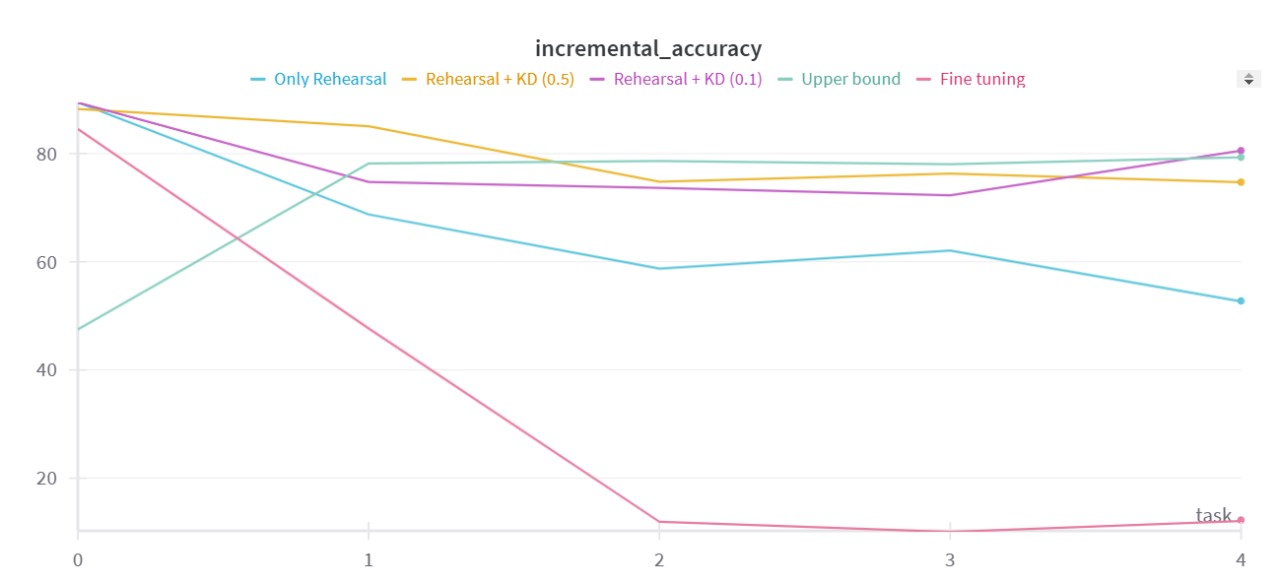